# Get data from NOW database
The [NOW](https://nowdatabase.org) (New and Old World) database is a database of fossil mammals (The NOW Community, 2023). Using the web interface, I downloaded a list of all occurrences of the genus _Mammuthus_.

In [1]:
# read the table (tab-separated)
mammuthus_df <- read.csv("Mammuthus/now_export_locsp_public_2023-10-20T07#11#49+0000.csv", sep="\t")

In [2]:
# packages used in this notebook.
# see here if not installed: https://nero-docs.stanford.edu/jupyter-installing-r-packages.html
library(dplyr)
library(ggplot2)
library(maps)
library(mapproj)
library(deeptime)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
print(paste("The table has", nrow(mammuthus_df), "entries and", ncol(mammuthus_df), "columns."))

[1] "The table has 500 entries and 102 columns."


## Cleanup and enhance the data
I will only keep rows with complete data for Genus, Species, Country, Latitude and Longitude, min age and max age. 
Note that min age and max age are derived from species.

In [4]:
mammuthus_clean <- mammuthus_df %>% 
   select(GENUS, SPECIES, COUNTRY, LAT, LONG, MAX_AGE, MIN_AGE, BODYMASS) %>%
   mutate(SPECIES = na_if(SPECIES, "indet.")) %>%  # drop rows without species
   mutate(BODYMASS = na_if(BODYMASS, "\\N")) %>%  # drop rows without body mass
   mutate_at("BODYMASS", as.numeric) %>%
   filter(!is.na(GENUS) & !is.na(SPECIES) & !is.na(LAT) & !is.na(LONG) &!is.na(BODYMASS))   

Add a column for epoch, based on max age. Epoch names are obtained from the list of epochs in the package deeptime.

In [5]:
getEpochName <- function(MAX_AGE) {
    return(filter(epochs, MAX_AGE < max_age)[1,]$name)
}
mammuthus_clean["epoch"] <- mammuthus_clean %>% select(MAX_AGE) %>% apply(1, getEpochName)

## Plotting European mammuth species on a map
I will use the maps package to plot the mammuth sites, by species and epoch, on a map of Europe.  

In [6]:
# bounding box for Europe
LAT1 = 70 ; LAT2 = 34
LON1 = -12 ; LON2 = 50

# keep only European specimens
mammuthus_clean <- mammuthus_clean %>%
   filter(LONG > LON1 & LONG < LON2 & LAT > LAT2 & LAT < LAT1)


In [7]:
# load a line map
world_df <- map_data("world")
# plot mammuth sites on the map using geom_plot, plot map using geom_path
map <- ggplot(mammuthus_clean) +
   # plot mammuth sites as points
   geom_point(aes(LONG, LAT, shape=SPECIES, color=epoch), size=2) +
   # plot map
   geom_path(aes(x=long, y=lat, group=group), data=world_df) +
   # Europe bounding box, mind the order of LONs and LATs
   xlim(c(LON1, LON2)) + ylim(c(LAT2, LAT1)) +
   theme_bw() + labs(title="European mammoth sites by species and epoch", x="Longitude", y="Latitude") +
   # set legend titles
   scale_color_discrete("Epoch") + scale_size_discrete("Species")

# re-order the legend 
mammuthus_clean$epoch <- factor(mammuthus_clean$epoch, levels = c("Holocene", "Pleistocene", "Pliocene", "Miocene"))

Warning message:
“Using size for a discrete variable is not advised.”


I used the Mollweide projection, which is an elliptical projection, i.e. meridians are ellipses. A [list of supported projections is here](https://cran.r-project.org/web/packages/mapproj/mapproj.pdf).

Warning message:
“Removed 82069 rows containing missing values (`geom_path()`).”


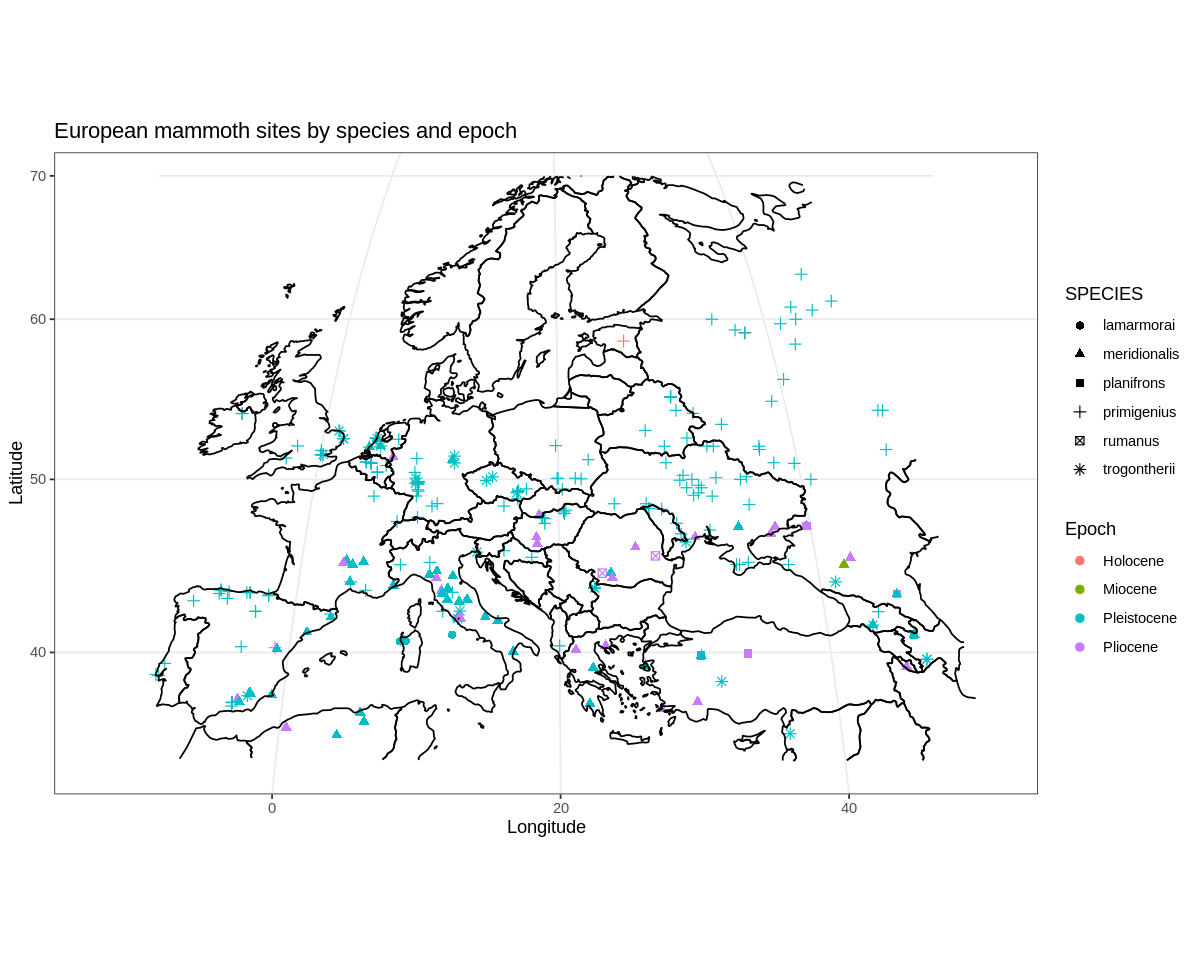

In [8]:
# compute a map projection
proj <- coord_map(
    projection="mollweide"
)
# size
options(repr.plot.width=10, repr.plot.height=8)
# display
map + proj

## Species succession in genus _Mammuthus_ 
Plot the estimated body weight against the age of the specimen for all species in the genera _Mammuthus_ in the data set.

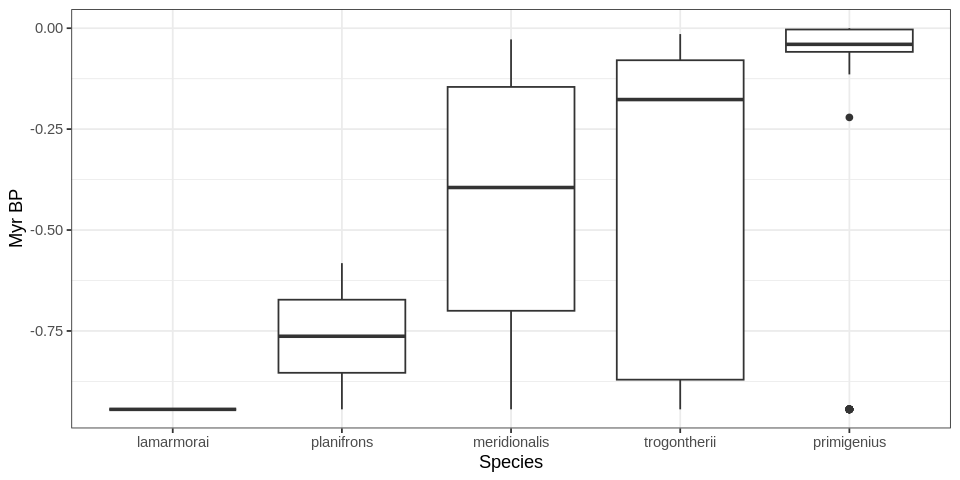

In [9]:
# plot size
options(repr.plot.width=8, repr.plot.height=4)
# keep only last 2 Myr
mammuthus_clean %>% filter(MAX_AGE < 2) %>%
# boxplot, reorder by age
ggplot() +
   geom_boxplot(aes(x=reorder(SPECIES, (MIN_AGE-MAX_AGE)/2), y=(MIN_AGE-MAX_AGE)/2)) +
   xlab("Species") + ylab("Myr BP") +
   theme_bw()

## Discussion
Most sites throughout the map area date from the Pleistocene, additionally there are a number of Pliocene sites in southern Europe, and one Miocene site in the Caucasus. 

During the Pleistocene, Northern Europe and Spain was populated by _Mammuthus primigenius_ (the woolly mammoth), while Southern Europe had a population of _Mammuthus meridionalis_ (the southern mammoth). Central Europe, the Balkans and the Caucasus was also populated by _Mammuthus trogontherii_ (the steppe mammoth). Actually the steppe and southern mammoth species went extinct earlier than the woolly mammoth.

The map shows a site in Estonia dating from the Holocene (< 11kY), that's very recent for a mammoth. Let's examine these Holocene sites:

In [10]:
mammuthus_clean %>% filter(epoch=="Holocene") %>% arrange(MIN_AGE)

GENUS,SPECIES,COUNTRY,LAT,LONG,MAX_AGE,MIN_AGE,BODYMASS,epoch
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Mammuthus,primigenius,Russia,59.13,37.90,0.00984,0.00976,4357667,Holocene
Mammuthus,primigenius,Estonia,58.58,26.28,0.01100,0.01100,4357667,Holocene


It appears that the last mammoths mainly lived in Russia about 10.000 BP.

## References

The NOW Community 2023. New and Old Worlds Database of Fossil Mammals (NOW). Licensed under CC BY 4.0. Retrieved [20. October 2023] from https://nowdatabase.org/now/database/.
DOI 10.5281/zenodo.4268068. 